#Demo NeuroEvolution usando Tensorflow-Neuroevolution framework (TFNE) para generar una red Convolucional que pueda aprender a clasificar en base a imágenes
Fuente TFNE: https://github.com/PaulPauls/Tensorflow-Neuroevolution

0) Preparar ambiente:

In [1]:
#@title Instalar TFNE
!pip install tfne

###!git clone https://github.com/PaulPauls/Tensorflow-Neuroevolution
###%cd Tensorflow-Neuroevolution
###!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 11.2 MB/s eta 0:00:00


1) Cargar librerías:

In [2]:
#@title Librerías a usar
from __future__ import annotations
from absl import app, flags, logging

import numpy as np
import tensorflow as tf
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image

import os
import csv

import tfne
from tfne.environments import BaseEnvironment
from tfne.helper_functions import read_option_from_config

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Determinar configuración:

In [21]:
#@title Parámetros para NeuroEvolution

#@markdown Criterio de Paro:
ce_maximo_generaciones_procesar = 5 #@param {type:"integer"}
ce_finalizar_al_encontrar_max_fitness = True #@param {type:"boolean"}
#@markdown Función de Aptitud:
fitness_calc_usando_exactitud = "Suma Entrenamiento & Validacion" #@param ["Entrenamiento", "Validacion", "Min Entrenamiento & Validacion", "Promedio Entrenamiento & Validacion", "Suma Entrenamiento & Validacion"]
fitness_penalizar_x_topologia = False #param {type:"boolean"}
#@markdown Blueprints (topología & optimizador):
ce_cant_poblacion_blueprints =  5#@param {type:"integer"}
#@markdown  Genomas (instancias de RNAs):
ce_cant_genomas_por_blueprint =  3#@param {type:"integer"}
#@markdown Módulos (capas RNA):
ce_cant_poblacion_modulos =  3#@param {type:"integer"}
ce_tipo_generacion_modulos = "Dinamica" #@param ["Basica", "Dinamica", "Fija"]
#@markdown Operadores Genéticos:
ce_max_mutacion = 0.5 #@param {type:"number"}
ce_probab_mutacion = 0.6 #@param {type:"number"}
ce_probab_cruzamiento = 0.4 #@param {type:"number"}
#@markdown Entrenamiento RNA:
rna_cant_epocas_entrenamiento = 50#@param {type:"integer"}
rna_cant_epocas_entrenamiento_incrementa_por_generacion = 25#@param {type:"integer"}
rna_cant_epocas_reentrenamiento_best_final =   350#@param {type:"integer"}



In [22]:
#@title Imágenes a Usar

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/imagenes/NUMEROS'  #@param {type:"string"}

#@markdown ### Subdirectorios de las imágenes:

path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

#@markdown ### Parámetros de imágenes:
imagen_largo_ancho = 16 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
imagen_usar_generadas_data_augmentation = True #@param {type:"boolean"}
tipo_output_softMax = True

## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, (3 if imagen_color else 1))

# indica si se usan las imágenes generadas por data augmentation
usarDA = imagen_usar_generadas_data_augmentation

# define tamaño de datos de entrada
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

print ("Tamaño Imagen: ", IMAGE_SHAPE)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tamaño Imagen:  (16, 16, 3)


In [23]:
#@title Cargar imágenes
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')

            if usarDA or (not esImagDA):

                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)

                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:
                  tipoImage = 'L'
                else:
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

                # transforma a un vector de nros
                arImag = np.array(imag)

                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
- Clases cargadas:  476
- Imágenes cargadas:  476
- Ejemplo  0   (16, 16, 3) : 




> Para Prueba: 
- Clases cargadas:  120
- Imágenes cargadas:  120
- Ejemplo  0   (16, 16, 3) : 


> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (476, 16, 16, 3)
 - y_train (cant):  (476,)


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (120, 16, 16, 3)
 - y_test (cant):  (120,)


> Para Ambos: 
 - dictMapeo:  {'8': 0, '3': 1, '4': 2, '0': 3, '6': 4, '5': 5, '1': 6, '9': 7, '7': 8, '2': 9}
 - clases_map:  ['8', '3', '4', '0', '6', '5', '1', '9', '7', '2']

 - Imagen reconstruida de  0 ( 3  /  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] )


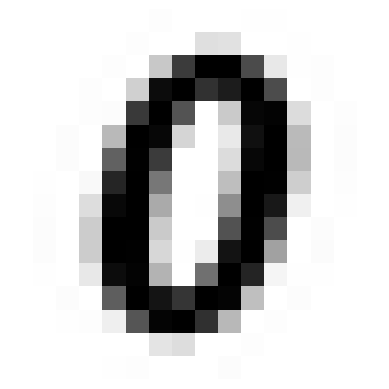

In [24]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList) ##.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
##print(" - y_trainEnc (cant): ", y_trainEnc.shape)
print(" - y_train (cant): ", y_train.shape)
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
##print(" - y_testEnc (cant): ", y_testEnc.shape)
print(" - y_test (cant): ", y_test.shape)
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

2) Preparar para NeuroEvolution:

In [25]:
#@title Crear Archivo Configuración
# ver explicación en https://tfne.readthedocs.io/en/latest/codeepneat/codeepneat-config.html

confFileName = './codeepneat_config.cfg'

s = ""
with open(confFileName, 'w') as f:
    s = s + "[EVALUATION]\n"
    s = s + "epochs        = " + str(rna_cant_epocas_entrenamiento) + "\n"
    s = s + "batch_size    = None\n"
    s = s + "preprocessing = None\n"
    if rna_cant_epocas_entrenamiento_incrementa_por_generacion > 0:
      s = s + "increase_epochs_every_n_genomes = " + str(ce_cant_poblacion_blueprints*ce_cant_genomas_por_blueprint) + "\n"
      s = s + "increase_epochs_add_epochs = " + str(rna_cant_epocas_entrenamiento_incrementa_por_generacion) + "\n"
    else:
      s = s + "increase_epochs_every_n_genomes = 0\n"
      s = s + "increase_epochs_add_epochs = 0\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[FITNESS]\n"
    if fitness_calc_usando_exactitud == "Entrenamiento":
      s = s + "calc_using_accuracy    = 'E'\n"
    elif fitness_calc_usando_exactitud == "Validacion":
      s = s + "calc_using_accuracy    = 'V'\n"
    elif fitness_calc_usando_exactitud == "Min Entrenamiento & Validacion":
      s = s + "calc_using_accuracy    = 'M'\n"
    elif fitness_calc_usando_exactitud == "Promedio Entrenamiento & Validacion":
      s = s + "calc_using_accuracy    = 'P'\n"
    else:
      s = s + "calc_using_accuracy    = 'S'\n"
    s = s + "penalize_based_on_topology  = " + str(fitness_penalizar_x_topologia) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[POPULATION]\n"
    s = s + "bp_pop_size    = " + str(ce_cant_poblacion_blueprints) + "\n"
    s = s + "mod_pop_size   = " + str(ce_cant_poblacion_modulos) + "\n"
    s = s + "genomes_per_bp = " + str(ce_cant_genomas_por_blueprint ) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[GENOME]\n"
    s = s + "dtype                = 'float32'\n"
  ##s = s + "available_modules    = ['DenseDropout', 'Conv2DMaxPool2DDropout']\n"
    s = s + "available_modules    = ['Conv2DMaxPool2DDropout']\n"
    s = s + "available_optimizers = ['SGD', 'Adam']\n" # 'SGD',
    s = s + "output_layers        = [{'class_name': 'Flatten', 'config': {}}, \n"
  ##s = s + "                        {'class_name': 'Dense', 'config': {'units': "+ str(len(clases_map)*2) + ", 'activation': 'relu'}}, \n"
    s = s + "                        {'class_name': 'Dense', 'config': {'units': "+ str(len(clases_map)) + ", 'activation': 'softmax'}}] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "mod_spec_type            = 'param-distance-dynamic'\n"
      s = s + "mod_spec_species_count   = 4\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 15\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "mod_spec_type            = 'param-distance-fixed'\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 10\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    else:
      # Basica
      s = s + "mod_spec_type          = 'basic'\n"
      s = s + "mod_spec_mod_elitism   = 4\n"
      s = s + "mod_spec_min_offspring = 1\n"
      s = s + "mod_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_EVOLUTION]\n"
    s = s + "mod_max_mutation   = " + str(ce_max_mutacion) + "\n"
    s = s + "mod_mutation_prob  = " + str(ce_probab_mutacion) + "\n"
    s = s + "mod_crossover_prob = " + str(ce_probab_cruzamiento) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_spec_type            = 'gene-overlap-dynamic'\n"
      s = s + "bp_spec_species_count   = 3\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "bp_spec_type            = 'gene-overlap-fixed'\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    else:
      # Basica
      s = s + "bp_spec_type          = 'basic'\n"
      s = s + "bp_spec_bp_elitism    = 2\n"
      s = s + "bp_spec_min_offspring = 1\n"
      s = s + "bp_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_EVOLUTION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.2\n"
      s = s + "bp_mutation_add_node_prob  = 0.2\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.3\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    else:
      # Fija o Basica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.3\n"
      s = s + "bp_mutation_add_node_prob  = 0.3\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.1\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
##    s = s + "\n"
##    s = s + "\n"
##    s = s + "[MODULE_DENSEDROPOUT]\n"
##    s = s + "merge_method = [{'class_name': 'Concatenate', 'config': {'axis': -1}}, {'class_name': 'Add', 'config': {}},{'class_name': 'Flatten', 'config': {}}]\n"
##    s = s + "units        = {'min': 2, 'max': 100, 'step': 4, 'stddev': 6}\n"
##    s = s + "activation   = ['linear', 'relu', 'sigmoid', 'softmax', 'tanh']\n"
##    s = s + "kernel_init  = ['glorot_normal', 'he_normal']\n"
##    s = s + "bias_init    = ['zeros']\n"
##    s = s + "dropout_flag = 0.5\n"
##    s = s + "dropout_rate = {'min': 0.1, 'max': 0.4, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_CONV2DMAXPOOL2DDROPOUT]\n"
    s = s + "merge_method  = [{'class_name': 'Concatenate', 'config': {'axis': -1}}, \n"
    s = s + "                 {'class_name': 'Add', 'config': {}}]\n"
    s = s + "filters       = {'min': 8, 'max': 256, 'step': 8, 'stddev': 4}\n"
    s = s + "kernel_size   = [1,2,3]\n"
    s = s + "strides       = [1]\n"
    s = s + "padding       = ['valid', 'same']\n"
    s = s + "activation    = ['linear', 'elu', 'relu']\n"
    s = s + "kernel_init   = ['glorot_uniform']\n"
    s = s + "bias_init     = ['zeros']\n"
    s = s + "max_pool_flag = 0.8\n"
    s = s + "max_pool_size = [1,2,3]\n"
    s = s + "dropout_flag  = 0.5\n"
    s = s + "dropout_rate  = {'min': 0.1, 'max': 0.7, 'step': 0.1, 'stddev': 0.2}\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_SGD]\n"
    s = s + "learning_rate = {'min': 0.001, 'max': 0.3, 'step': 0.001, 'stddev': 0.02}\n"
    s = s + "momentum      = {'min': 0.3, 'max': 0.7, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "nesterov      = [True, False] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_ADAM]\n"
    s = s + "learning_rate = {'min': 0.0001, 'max': 0.3, 'step': 0.0001, 'stddev': 0.02}\n"
    s = s + "beta_1        = {'min': 0.6, 'max': 1.5, 'step': 0.05, 'stddev': 0.2}\n"
    s = s + "beta_2        = {'min': 0.8, 'max': 1.2, 'step': 0.001, 'stddev': 0.1}\n"
    s = s + "epsilon       = {'min': 1e-8, 'max': 1e-6, 'step': 1e-8, 'stddev': 1e-7}\n"
    s = s + "\n"
    s = s + "\n"

    f.write(s)

# muestra nuevo archivo modificado
%cat {confFileName}

[EVALUATION]
epochs        = 50
batch_size    = None
preprocessing = None
increase_epochs_every_n_genomes = 15
increase_epochs_add_epochs = 25


[FITNESS]
calc_using_accuracy    = 'S'
penalize_based_on_topology  = False


[POPULATION]
bp_pop_size    = 5
mod_pop_size   = 3
genomes_per_bp = 3


[GENOME]
dtype                = 'float32'
available_modules    = ['Conv2DMaxPool2DDropout']
available_optimizers = ['SGD', 'Adam']
output_layers        = [{'class_name': 'Flatten', 'config': {}}, 
                        {'class_name': 'Dense', 'config': {'units': 10, 'activation': 'softmax'}}] 


[MODULE_SPECIATION]
mod_spec_type            = 'param-distance-dynamic'
mod_spec_species_count   = 4
mod_spec_distance        = 0.3
mod_spec_mod_elitism     = 2
mod_spec_min_offspring   = 1
mod_spec_reprod_thres    = 0.5
mod_spec_max_stagnation  = 15
mod_spec_species_elitism = 2
mod_spec_rebase_repr     = True
mod_spec_reinit_extinct  = False


[MODULE_EVOLUTION]
mod_max_mutation   = 0.5
mod_mutation_pro

In [26]:
#@title Definir clase para el ambiente RNAEnvironment

class RNAEnvironment(BaseEnvironment):
    """
    TFNE compatible environment for the RNA
    """

    def __init__(self, weight_training, data_x, data_y, config=None, verbosity=0, **kwargs):
        """
        Initializes environment by setting up the dataset and processing the supplied config or supplied config
        parameters. The configuration of the environment can either be supplied via a config file or via seperate config
        parameters in the initialization.
        @param weight_training: bool flag, indicating wether evaluation should be weight training or not
        @param config: ConfigParser instance holding an 'Environment' section specifying the required environment
                       parameters for the chosen evaluation method.
        @param verbosity: integer specifying the verbosity of the evaluation
        @param kwargs: Optionally supplied dict of each configuration parameter seperately in order to allow the
                       creation of the evaluation environment without the requirement of a config file.
        """
        # Initialize corresponding input and output mappings
        print("> Preparando el ambiente...")

        # Initialize loss function to evaluate performance on either evaluation method and safe verbosity parameter
        self.accuracy_metric = tf.keras.metrics.Accuracy()
        self.verbosity = verbosity

        # Determine and setup explicit evaluation method in accordance to supplied parameters
        if not weight_training:
              raise NotImplementedError("RNA environment is being set up as non-weight training, though non-weight "
                                      "training evaluation not yet implemented for RNA environment")


        elif config is None and len(kwargs) == 0:
            raise RuntimeError("No se han definido los parámetros para poder realizar la evolución y el entrenamiento de las RNA")

        elif len(kwargs) == 0:
            # Set up environment as weight training and with a supplied config file
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = read_option_from_config(config, 'EVALUATION', 'epochs')
            self.batch_size = read_option_from_config(config, 'EVALUATION', 'batch_size')
            self.increase_epochs_every_n_genomes = read_option_from_config(config, 'EVALUATION', 'increase_epochs_every_n_genomes')
            self.increase_epochs_add_epochs = read_option_from_config(config, 'EVALUATION', 'increase_epochs_add_epochs')
            #  parámetros para calculo fitness
            self.calcFitness = read_option_from_config(config, 'FITNESS', 'calc_using_accuracy')
            self.penalFitness = read_option_from_config(config, 'FITNESS', 'penalize_based_on_topology')

        elif config is None:
            # Set up environment as weight training and explicitely supplied parameters
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = kwargs['epochs']
            self.batch_size = kwargs['batch_size']
            self.increase_epochs_every_n_genomes = kwargs['increase_epochs_every_n_genomes']
            self.increase_epochs_add_epochs = kwargs['increase_epochs_add_epochs']
            # determina parámetros para calculo fitness
            self.calcFitness = kwargs['fitness_calc_using_accuracy']
            self.penalFitness = kwargs['fitness_penalize_based_on_topology']

        print(" Definiendo parámetros para cálculo de aptitud: ")
        print("        calcFitness = ", self.calcFitness)
        print("        penalFitness = ", self.penalFitness)


        ##data_y = np.squeeze(data_y)
        if self.calcFitness == "E":
            # se toman todos los datos para entrenamiento
            x_t, x_v, y_t, y_v = data_x, [], data_y, []
        else:
            # separa al azar usando muestreo al azar del 10%
            # para tomar algunos como datos de validación
            x_t, x_v, y_t, y_v = train_test_split(data_x,
                                                data_y,
                                                test_size=0.1)

        print("  Definiendo datos: de los ", len(x_train), "ejemplos de entrenamiento: ")
        print("                      se usan ", len(x_t), "ejemplos para entrenar ")
        print("                      y ", len(x_v), "ejemplos para validar.")
        print("\n")
        self.x_train = np.array(x_t)
        self.y_train = np.array(y_t)

        # genera salida codificada para entrenamiento con capa softMax
        self.y_trainEnc = to_categorical(self.y_train)

        self.x_val = np.array(x_v)
        self.y_val = np.array(y_v)

        # determina neuronas de entrada y salida
        self.cantX = len(self.x_train)
        self.cantY = len(self.y_train)
        return

    def eval_genome_fitness(self, genome) -> float:
        # TO BE OVERRIDEN
        raise RuntimeError()

    def _calculate_fitness(self, model, penalFitness=False) -> float:
        """
        The genomes fitness is then calculated and returned as
        the percentage of training and/or validation examples classified correctly.
        """
        # calcula para datos de entrenamiento
        if len(self.y_train)>0:
          self.accuracy_metric.reset_states()
          self.accuracy_metric.update_state(self.y_train, np.argmax(model(self.x_train), axis=-1))
          evaluated_fitness_train = round(self.accuracy_metric.result().numpy() * 100, 4)
        else:
          evaluated_fitness_train = 0.0
        # calcula para datos de entrenamiento
        if len(self.y_val)>0:
          self.accuracy_metric.reset_states()
          self.accuracy_metric.update_state(self.y_val, np.argmax(model(self.x_val), axis=-1))
          evaluated_fitness_val = round(self.accuracy_metric.result().numpy() * 100, 4)
        else:
          evaluated_fitness_val = 0.0
        # calcula final como promedio
        if self.calcFitness == "E":
          # sólo de entrenamiento
          evaluated_fitness = evaluated_fitness_train
        elif self.calcFitness == "V":
          # sólo de validación
          evaluated_fitness = evaluated_fitness_val
        elif self.calcFitness == "P":
          # promedio ente ambos
          evaluated_fitness = (evaluated_fitness_train + evaluated_fitness_val)/2
        elif self.calcFitness ==  "S":
          # suma ente ambos
          evaluated_fitness = (evaluated_fitness_train + evaluated_fitness_val)
        else:
          # mínimo ente ambos
          evaluated_fitness = min([evaluated_fitness_train, evaluated_fitness_val])
        if False and penalFitness:
          # sólo se aplica la penalización
          # si está cercano a alcanzar la aptitud máxima
          maxFit = self.return_MaxFitness()
          if evaluated_fitness >= (maxFit - 11):
            # penaliza aptitud teniendo en cuenta la complejidad de la RNA
            penalLayers = -1.5
            ajusteCantPesos = self.cantX
            for i in range(len(model.layers)):
              l = model.layers[i]
              tipoLay = str(type(l))
              if "Dense" in tipoLay:
                if i > 1:
                  # contabiliza en base a la cantidad de pesos de las conexiones
                  # nota: no tiene en cuenta los pesos de la capa de entrada ni de salida
                  cantPesos = len(l.get_weights()[0])
                  penalLayers = penalLayers + (cantPesos / ajusteCantPesos)
              elif "Dropout" in tipoLay:
                penalLayers = penalLayers + 0.8
              elif "Concatenate" in tipoLay:
                penalLayers = penalLayers + 0.9
            if penalLayers > 0:
              evaluated_fitness = evaluated_fitness + 10.0 - (penalLayers / 10.0)
        return round(evaluated_fitness, 5)

    def return_MaxFitness(self) -> float:
      # devuelve valor máximo posible para la aptitud
      if self.calcFitness ==  "S":
        valMaxFit = 200.0
      else:
        valMaxFit = 100.0
      if self.penalFitness:
        valMaxFit = valMaxFit + 10
      return valMaxFit

    def _eval_genome_fitness_weight_training(self, genome) -> float:
        """
        Evaluates the genome's fitness by obtaining the associated Tensorflow model and optimizer,
        compiling them and then training them for the config specified duration.
        @param genome: TFNE compatible genome that is to be evaluated
        @return: genome calculated fitness
        """
        # Get model and optimizer required for compilation
        model = genome.get_model()
        optimizer = genome.get_optimizer()

        # si corresponde incrementa la cantidad de épocas
        gen_id = genome.get_id()
        if gen_id > self.increase_epochs_every_n_genomes:
          cantEpochsIncr = int((gen_id / self.increase_epochs_every_n_genomes) * self.increase_epochs_add_epochs)
          cant_epochs = self.epochs + cantEpochsIncr
          #print("  > ", gen_id, self.epochs, cantEpochsIncr, cant_epochs)
        else:
          cant_epochs = self.epochs

        # Compile and train model
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy', metrics=['accuracy'])
                      #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
        model.fit(x=self.x_train,
                  y=self.y_trainEnc,
                  epochs=cant_epochs,
                  batch_size=self.batch_size,
                  verbose=self.verbosity)

        # Evaluate and return its fitness
        return self._calculate_fitness(model, self.penalFitness)

    def _eval_genome_fitness_non_weight_training(self, genome) -> float:
        raise NotImplementedError("Non-Weight training evaluation not yet implemented for Environment")

    def replay_genome(self, genome):
        """
        Replay genome on environment by calculating its fitness and printing it.
        @param genome: TFNE compatible genome that is to be evaluated
        """
        print("> Probando Genome #{}:".format(genome.get_id()))

        # Determine fitness by creating model predictions with test images and then judging the fitness based on the
        # achieved model accuracy.
        model = genome.get_model()
        evaluated_fitness = self._calculate_fitness(model, False)
        print("  Aptitud lograda:\t{}\n".format(evaluated_fitness))

    def duplicate(self) -> RNAEnvironment:
        """
        @return: New instance of the environment with identical parameters
        """
        x = self.x_train.extend(self.x_val)
        y = self.y_train.extend(self.y_val)
        if hasattr(self, 'epochs'):
            return RNAEnvironment(True, data_x=x, data_y=y, verbosity=self.verbosity, epochs=self.epochs, batch_size=self.batch_size)
        else:
            return RNAEnvironment(False, data_x=x, data_y=y, verbosity=self.verbosity)

    def get_input_shape(self) -> (int, int, int):
        """"""
        if len(self.x_train)>0:
          return self.x_train[0].shape
        else:
          return None

    def get_output_shape(self) ->  (int,):
        """"""
        return (self.cantY,)
        #if len(self.y_train)>0:
        #  return self.y_train[0].shape
        #else:
        #  return None

print("Clase RNAEnvironment definida")

Clase RNAEnvironment definida


3) Ejecutar NeuroEvolution:

In [27]:
#@title Ejecutar NeuroEvolution

logging_level = logging.INFO
config_file_path = confFileName # './codeepneat_xor_basic_example_config.cfg'
backup_dir_path = './tfne_state_backups/'
max_generations = ce_maximo_generaciones_procesar

# Set logging, parse config
logging.set_verbosity(logging_level)
config = tfne.parse_configuration(config_file_path)

# Initialize the environment and the specific NE algorithm
environment = RNAEnvironment(weight_training=True,
                              data_x=x_train,
                              data_y=y_train,
                              config=config,
                              verbosity=logging_level)

print("\n>  Definiendo Enviroment:")
print("input_shape: ", environment.get_input_shape())
print("output_shape: ", environment.get_output_shape())
print("")

print(">  Definiendo configuración:")
ne_algorithm = tfne.algorithms.CoDeepNEAT(config)

# determina si termina por alcanzar la máxima o no
if ce_finalizar_al_encontrar_max_fitness:
  max_fitness = environment.return_MaxFitness()
else:
  max_fitness = None


# Initialize evolution engine and supply config as well as initialized NE algorithm and evaluation environment.
engine = tfne.EvolutionEngine(ne_algorithm=ne_algorithm,
                              environment=environment,
                              backup_dir_path=backup_dir_path,
                              max_generations=max_generations,
                              max_fitness=max_fitness)

# Start training process, returning the best genome when training ends
best_genome = engine.train()

print("\n> Mejor RNA generada por la evolución:\n")
print(best_genome)
print("\n")

# Graba mejor genotipo y su modelo TF antes del re-entrenamiento
best_genotype_ori_dir = './best_genome_genotype_ori/'
best_model_ori_dir = './best_genome_model_ori/'
best_genome.save_genotype(save_dir_path=best_genotype_ori_dir)
best_genome.save_model(file_path=best_model_ori_dir)

# Re-entrena mejor genotipo para ver si mejora
print("\n\n")
environment.epochs = rna_cant_epocas_reentrenamiento_best_final
print("> Re-entrenando mejor RNA por "+str(environment.epochs)+" épocas...\n")
environment.eval_genome_fitness(best_genome)
environment.replay_genome(best_genome)

# Graba mejor genotipo y su modelo TF después del re-entrenamiento
print("\n")
best_genotype_new_dir = './best_genome_genotype/'
best_model_new_dir = './best_genome_model/'
best_genome.save_genotype(save_dir_path=best_genotype_new_dir)
best_genome.save_model(file_path=best_model_new_dir)


> Preparando el ambiente...
Config value for 'EVALUATION/epochs': 50
Config value for 'EVALUATION/batch_size': None
Config value for 'EVALUATION/increase_epochs_every_n_genomes': 15
Config value for 'EVALUATION/increase_epochs_add_epochs': 25
Config value for 'FITNESS/calc_using_accuracy': S
Config value for 'FITNESS/penalize_based_on_topology': False
 Definiendo parámetros para cálculo de aptitud: 
        calcFitness =  S
        penalFitness =  False
  Definiendo datos: de los  476 ejemplos de entrenamiento: 
                      se usan  428 ejemplos para entrenar 
                      y  48 ejemplos para validar.



>  Definiendo Enviroment:
input_shape:  (16, 16, 3)
output_shape:  (428,)

>  Definiendo configuración:
Config value for 'POPULATION/bp_pop_size': 5
Config value for 'POPULATION/mod_pop_size': 3
Config value for 'POPULATION/genomes_per_bp': 3
Config value for 'GENOME/dtype': float32
Config value for 'GENOME/available_modules': ['Conv2DMaxPool2DDropout']
Config value 

INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_biasadd_readvariableop_resource in the SavedModel.
INFO:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to ./best_genome_model_ori/fingerprint.pb





> Re-entrenando mejor RNA por 350 épocas...

> Probando Genome #62:
  Aptitud lograda:	194.8987



Saved CoDeepNEAT genome (ID: 62) to file: ./best_genome_genotype/genome_62_genotype.json


INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_biasadd_readvariableop_resource in the SavedModel.
INFO:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to ./best_genome_model/fingerprint.pb


4) Evaluar el modelo de la RNA generada:

In [31]:
#@title Cargar modelo de mejor genoma de RNA generada

usar_modelo = "Re-Entrenado" #@param ["Original", "Re-Entrenado"]

if usar_modelo == "Original":
  best_model_dir = best_model_ori_dir
else:
  best_model_dir= best_model_new_dir

modelRNA = tf.keras.models.load_model(best_model_dir)
print("\nModelo recuperado de ", best_model_dir)

print("\n")
modelRNA.summary()
print("\n")



Modelo recuperado de  ./best_genome_model/


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 208)       832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 208)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 208)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 208)       43472     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 208)       0         
 g2D)          

In [32]:
#@title Probar RNA con datos de entrenamiento
mostrar_detalle_imagenes_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, mostrarImagenes=False):

    # procesa las imágenes de prueba con el modelo
    predClass = modelRNA.predict(x)

    # muestra los resultados con las imágenes
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

        # sólo muestra las imágenes no generadas por DA
        if mostrarImagenes:
          strTitulo = 'Real: ' + clReal + ' / RNA: '
          strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'

          # muestra comparación con la imagen
          fig = plt.figure()
          fig.suptitle( strTitulo )
          ax1 = fig.add_subplot(121)
          plot_image( x[i] )

          plt.tight_layout()
          fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    if mostrarImagenes:
      print("\n>Resultados: ")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map, mostrar_detalle_imagenes_entrenamiento)


*** Resultados con datos de Entrenamiento: 
15/15 [==============================] - 0s 3ms/step

 Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        44
           3       1.00      0.92      0.96        48
           4       0.96      1.00      0.98        48
           5       0.92      1.00      0.96        48
           6       1.00      0.96      0.98        48
           7       1.00      1.00      1.00        48
           8       1.00      1.00      1.00        48
           9       1.00      1.00      1.00        48

    accuracy                           0.99       476
   macro avg       0.99      0.99      0.99       476
weighted avg       0.99      0.99      0.99       476


Matriz de Confusión: 
     p:8  p:3  p:4  p:0  p:6  p:5  p:1  p:9  p:7  p:2
r:8   48    0    0    0    0    0    0

In [33]:
#@title Probar RNA con datos de prueba

mostrar_detalle_imagenes_prueba = False #@param {type:"boolean"}

print("*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_train, clases_map, mostrar_detalle_imagenes_prueba)


*** Resultados con datos de Prueba: 
4/4 [==============================] - 0s 3ms/step

 Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       1.00      0.83      0.91        12
           2       1.00      1.00      1.00        12
           3       0.86      1.00      0.92        12
           4       0.80      0.67      0.73        12
           5       0.71      0.83      0.77        12
           6       0.60      0.50      0.55        12
           7       0.71      0.83      0.77        12
           8       0.62      0.83      0.71        12
           9       1.00      0.83      0.91        12

    accuracy                           0.80       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.81      0.80      0.80       120


Matriz de Confusión: 
     p:8  p:3  p:4  p:0  p:6  p:5  p:1  p:9  p:7  p:2
r:8   10    2    0    0    0    0    0    0    